# Negation detection with ConText

## Setup

In [97]:
%load_ext autoreload
import pathlib
import sys
import pickle
import pandas as pd
import spacy
import numpy as np
import pandas as pd
from spacy import displacy
from spacy.tokens import Span, Doc
import medspacy
from medspacy.visualization import visualize_dep
from medspacy.context import ConTextRule, ConTextComponent
from sklearn.metrics import classification_report
from collections import defaultdict
# until bug is fixed in v6 of ipython kernel
import warnings
warnings.simplefilter('once')

sys.path.insert(0, '/home/bramiozo/DEV/GIT/UPOD/negation-detection')
import utils.DataSetSplitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Recreate the spacy pipeline:

In [22]:
nlp = spacy.load(pathlib.Path('..','..','data','MedSpacy_pipeline'))
# Load the custom attributes set during labeling
Doc.set_extension("data_type", default=None)
Doc.set_extension("doc_id", default=None)
Span.set_extension("entity_id", default=None)
Span.set_extension("negation", default="NotNegated")
Span.set_extension("experiencer", default="Patient")
Span.set_extension("temporality", default="Recent")

### Load texts, rules:

In [23]:
docs_file = pathlib.Path('..','..','data', 'EMCDutchClinicalCorpus', 'DCC_docs.pickle')
preproc_docs = pickle.loads(docs_file.read_bytes())

In [24]:
context_file = pathlib.Path('..','configs','context','contextD_triggers.json') # all negation triggers in test set from ContextD

In [25]:
context = ConTextComponent(nlp, rules="other", rule_list=str(context_file))

In [6]:
result_file = pathlib.Path('..', '..', 'results', 'rule-based_predictions.csv.gz')

## Example

In [26]:
[example_doc] = [d for d in preproc_docs if d._.doc_id == 'DL1112']

In [27]:
displacy.render(example_doc, style='ent')

Add ConText:

In [28]:
# Run just the context component; visualize the result
visualize_dep(context(example_doc))

## Run "ContextD on all docs

In [29]:
%%time
docs = []
for doc in preproc_docs:
    docs.append(context(doc))

CPU times: user 872 ms, sys: 3 ms, total: 875 ms
Wall time: 873 ms


## Score performance

### Negation

Table of all predictions:

In [11]:
res = []
for d in docs:
    for e in d.ents:
        res.append({'entity_id': e._.entity_id,
                    'annotation': 'negated' if e._.negation=='Negated' else 'not negated',
                    'rule_based': 'negated' if e._.is_negated else 'not negated'})
pd.DataFrame(res).to_csv(result_file, index=False, compression='gzip')

#### Total

In [30]:
trues = [True if e._.negation=='Negated' else False for d in docs for e in d.ents]
trues_all = [(True, e,i,j) if e._.negation=='Negated' else (False,e,i,j) for i,d in enumerate(docs)
                                                                 for j,e in enumerate(d.ents)]
preds = [e._.is_negated for d in docs for e in d.ents]
preds_all = [(True, e,i,j) if e._.is_negated else (False, e,i,j) for i,d in enumerate(docs)
                                                                 for j,e in enumerate(d.ents)]
target_names = ['not negated', 'negated']

In [31]:
print(classification_report(trues, preds, target_names=target_names))

              precision    recall  f1-score   support

 not negated       0.98      0.97      0.98     10791
     negated       0.82      0.89      0.86      1760

    accuracy                           0.96     12551
   macro avg       0.90      0.93      0.92     12551
weighted avg       0.96      0.96      0.96     12551



#### Per document type

In [32]:
data_types = ['GP', 'SP', 'RD', 'DL']
results = defaultdict(list)
for dt in data_types:
    trues = [True if e._.negation=='Negated' else False for d in docs if d._.data_type==dt for e in d.ents]
    trues_all = [(True, e,i,j) if e._.negation=='Negated' else (False,e,i,j) 
                                                                 for i,d in enumerate(docs)
                                                                 if d._.data_type==dt
                                                                 for j,e in enumerate(d.ents) 
                                                                  ]
    preds = [e._.is_negated for d in docs if d._.data_type==dt for e in d.ents]
    preds_all = [(True, e, i,j) if e._.is_negated else (False, e, i,j) 
                                                                 for i,d in enumerate(docs)
                                                                 if d._.data_type==dt                                                                  
                                                                 for j,e in enumerate(d.ents)
                                                                 ]
    
    results[dt] = {'trues': trues_all, 'preds': preds_all}
    
    print(f"Data type: {dt}")
    print(classification_report(trues, preds, target_names=target_names))

Data type: GP
              precision    recall  f1-score   support

 not negated       0.97      0.95      0.96      3013
     negated       0.67      0.80      0.73       383

    accuracy                           0.93      3396
   macro avg       0.82      0.88      0.85      3396
weighted avg       0.94      0.93      0.94      3396

Data type: SP
              precision    recall  f1-score   support

 not negated       0.97      0.96      0.97      2273
     negated       0.81      0.84      0.82       403

    accuracy                           0.95      2676
   macro avg       0.89      0.90      0.89      2676
weighted avg       0.95      0.95      0.95      2676



/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data type: RD
              precision    recall  f1-score   support

 not negated       0.99      0.98      0.99      3088
     negated       0.90      0.97      0.93       595

    accuracy                           0.98      3683
   macro avg       0.95      0.97      0.96      3683
weighted avg       0.98      0.98      0.98      3683

Data type: DL
              precision    recall  f1-score   support

 not negated       0.99      0.98      0.99      2417
     negated       0.89      0.92      0.91       379

    accuracy                           0.97      2796
   macro avg       0.94      0.95      0.95      2796
weighted avg       0.97      0.97      0.97      2796



Compare to paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-014-0373-3/tables/5

- **GP**: 
    - Precision and recall much worse than in paper. Probably because we haven't added the GP-specific tweaks for the rules yet?
    - Also here recall is higher than precision; other way around in paper (for baseline)
- **SP**: Performance pretty similar (couple points worse)
- **RD**: Performance almost exactly the same as in paper (for final)
- **DL**: Performance pretty similar (bit worse)

# Failure modes

In [33]:
false_negatives = dict()
false_positives = dict()
false_negatives['GP'] = [t for i,t in enumerate(results['GP']['trues']) if (t[0]!=results['GP']['preds'][i][0]) &\
                                                                           (t[0]==True)]
false_positives['GP'] = [t for i,t in enumerate(results['GP']['trues']) if (t[0]!=results['GP']['preds'][i][0]) &\
                                                                           (t[0]==False)]

In [38]:
n = 10
false_negatives['GP'][n], displacy.render(context(docs[false_negatives['GP'][n][2]]), style='ent')

((True, zwelling, 1295, 0), None)

## Cross-validation

In [40]:
# load folds per letter type
# docs[0]._.doc_id is in fold_test list
dcc_path = "../../data"
ids_df = utils.DataSetSplitter.get_ids_dataframe(corpus_path = dcc_path)

100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18236.10it/s]


In [148]:
n_reps = 100
n_folds = 10
intra_folds = utils.DataSetSplitter.get_intra_group_folds(ids_df = ids_df,
                                                          num_reps = n_reps,
                                                          num_folds = n_folds)

1000it [00:00, 2187.46it/s]
1000it [00:00, 1788.16it/s]
1000it [00:00, 2277.40it/s]
1000it [00:00, 1868.85it/s]


In [149]:
# make docs searchable by doc_id
docs_plus = defaultdict(list)
for d in docs: 
    for e in d.ents:
        docs_plus[d._.doc_id] += [e]      

In [150]:
def get_preds_trues(documents, val_list):
    # process all ents per doc, append to res lists
    trues, preds = [], []
    for v in val_list:
        for e in documents[v]:
            trues.append(e._.negation=='Negated')
            preds.append(e._.is_negated)
    return np.array(trues, dtype=bool), np.array(preds, dtype=bool)

In [151]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [152]:
def specificity_score(trues,preds):
    return sum(trues==False)/(sum(trues==False) + sum((preds!=trues) & (trues==False)))

def sensitivity_score(trues,preds):
    return sum(trues==True)/(sum(trues==True) + sum((preds!=trues) & (trues==True)))  

In [153]:
metrics_list = []
for g in ['GP', 'SP', 'RD', 'DL']:
    for k in range(n_reps*n_folds):
        _trues, _preds = get_preds_trues(documents=docs_plus, 
                                         val_list=intra_folds[g][k][1])

        f1  = f1_score(_trues, _preds)
        acc = accuracy_score(_trues, _preds)
        precision = precision_score(_trues, _preds)
        specificity = specificity_score(_trues, _preds)
        sensitivity = sensitivity_score(_trues, _preds)
        recall = recall_score(_trues, _preds)
        metrics_list.append({'f1': f1, 
                             'acc': acc,
                             'precision': precision, 
                             'recall': recall, 
                             'specificity': specificity,
                             'sensitivity': sensitivity,
                             'group': g})
        
scores = pd.DataFrame(metrics_list)

In [157]:
scores.groupby('group').mean()

,f1,acc,precision,recall,specificity,sensitivity
group,,,,,,
DL,0.820194,0.945518,0.809983,0.836718,0.966371,0.863153
GP,0.784377,0.941111,0.751367,0.824784,0.960445,0.853367
RD,0.803948,0.944945,0.783360,0.830513,0.964727,0.857817
SP,0.820194,0.945518,0.809983,0.836718,0.966371,0.863153


## Visualise scores

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'sensitivity score')

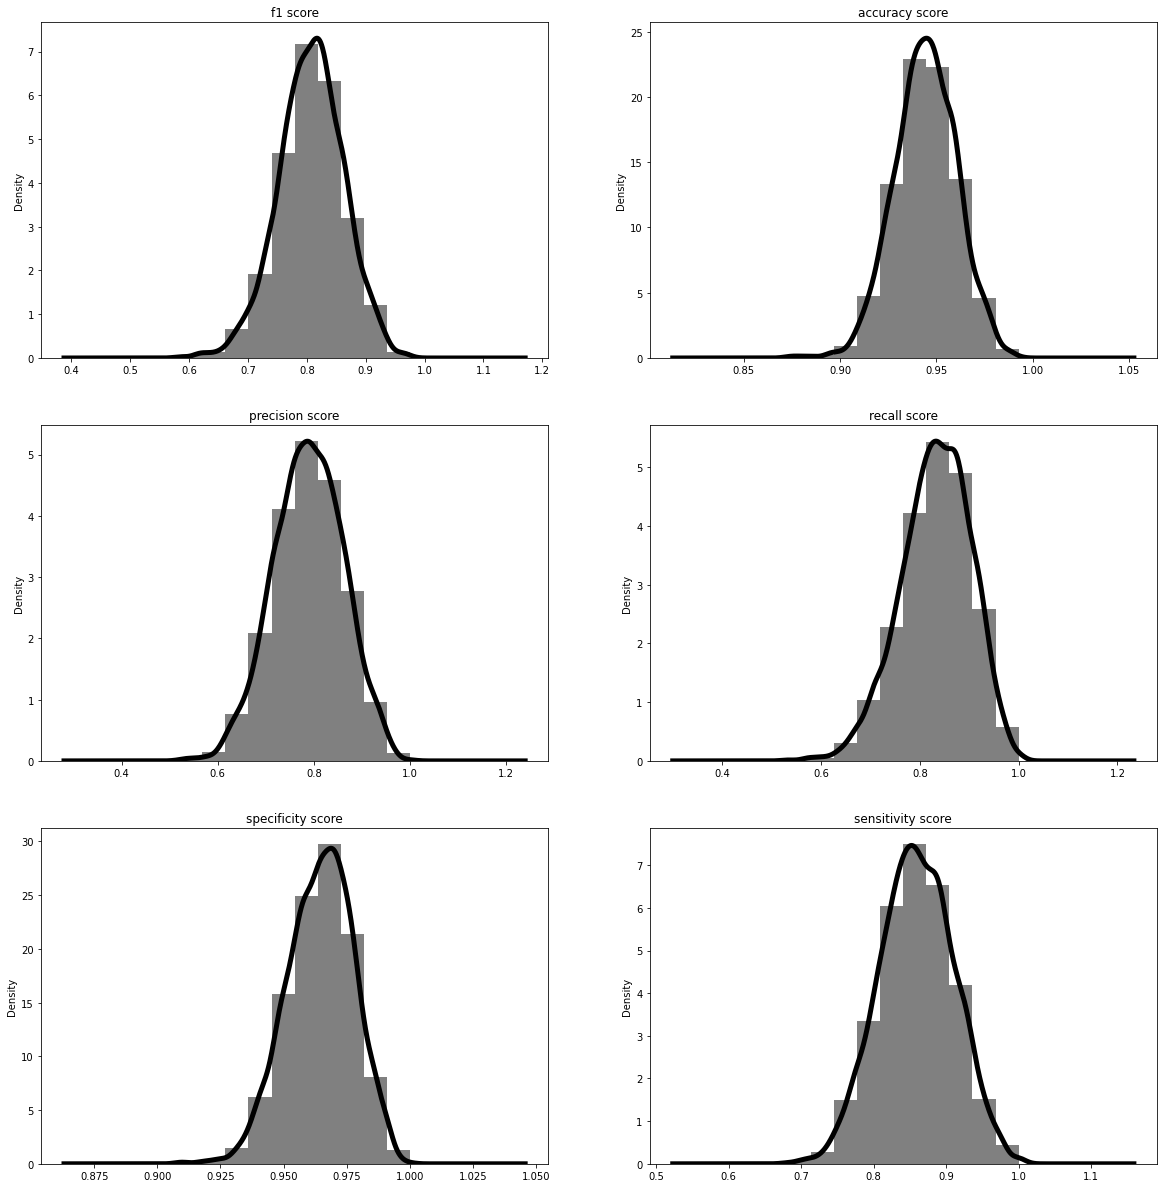

In [156]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20,21))

scores['f1'].hist(ax=ax[0,0], density=True, color='grey')
scores['acc'].hist(ax=ax[0,1], density=True, color='grey')
scores['precision'].hist(ax=ax[1,0], density=True, color='grey')
scores['recall'].hist(ax=ax[1,1], density=True, color='grey')
scores['specificity'].hist(ax=ax[2,0], density=True, color='grey')
scores['sensitivity'].hist(ax=ax[2,1], density=True, color='grey')

scores['f1'].plot.kde(ax=ax[0,0], color='black', lw=5)
scores['acc'].plot.kde(ax=ax[0,1], color='black', lw=5)
scores['precision'].plot.kde(ax=ax[1,0], color='black', lw=5)
scores['recall'].plot.kde(ax=ax[1,1], color='black', lw=5)
scores['specificity'].plot.kde(ax=ax[2,0], color='black', lw=5)
scores['sensitivity'].plot.kde(ax=ax[2,1], color='black', lw=5)

ax[0,0].set_title('f1 score')
ax[0,1].set_title('accuracy score')
ax[1,0].set_title('precision score')
ax[1,1].set_title('recall score')
ax[2,0].set_title('specificity score')
ax[2,1].set_title('sensitivity score')


In [158]:
import joypy

group,DL,GP,RD,SP
0,NaN,0.785714,NaN,NaN
1,NaN,0.821192,NaN,NaN
2,NaN,0.846154,NaN,NaN
3,NaN,0.740741,NaN,NaN
4,NaN,0.729167,NaN,NaN
...,...,...,...,...
3995,0.851064,NaN,NaN,NaN
3996,0.803922,NaN,NaN,NaN
3997,0.845361,NaN,NaN,NaN
3998,0.757576,NaN,NaN,NaN


Text(0.5, 0.98, 'F1 score')

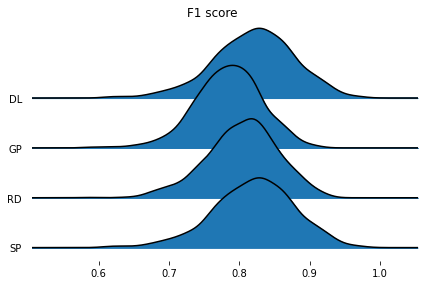

In [167]:
fig, axes = joypy.joyplot(scores[['f1', 'group']].pivot(columns='group', values='f1'))
fig.suptitle('F1 score')

Text(0.5, 0.98, 'Accuracy score')

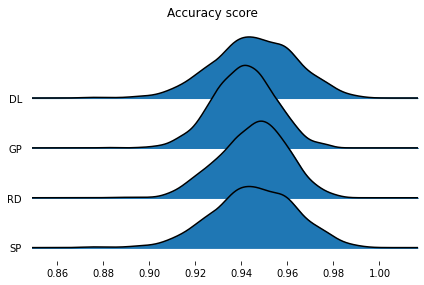

In [169]:
fig, axes = joypy.joyplot(scores[['acc', 'group']].pivot(columns='group', values='acc'))
fig.suptitle('Accuracy score')

Text(0.5, 0.98, 'Precision score')

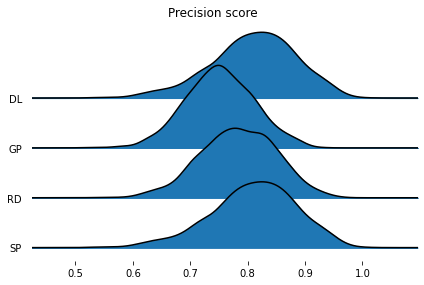

In [170]:
fig, axes = joypy.joyplot(scores[['precision', 'group']].pivot(columns='group', values='precision'))
fig.suptitle('Precision score')